## Synthetic Experiment

In [17]:
%load_ext autoreload
%autoreload 2

import pickle
from collections import defaultdict

import numpy as np
from sklearn import decomposition
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from plot_data import plot_dataset_2d, plot_syth_exp, plot_2d_with_movement, plot_2d_grid
import torch
from torch import nn
from delta import QuadraticCost, QuadraticCostDelta, QuadraticCostDeltaInverse
from model import PolynomialModel, hinge_loss, CrossEntropy, weighted_hinge_loss, cross_entropy_loss_for_h, StochasticModel
from utils import split_data, calc_accuracy, local_seed, split_vector, set_seed, create_Y, create_uniform_samples, Data, ExplorationParams
from torch.optim import Adam
from training import NonStrategicTrainer, StrategicTrainer, CausalStrategicTrainer, IterativeCausalStrategicTrainer, IterativeNonStrategicTrainer, CausalStrategicTrainerWithU
from distribution import CustomSyntheticDataDistribution2, SyntheticDistribution2D
from testing import test, test_with_h_star, test_strategic, test_strategic_only_X2_model
from experiment_2d_synth import Experiment2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import math

x1_dim = 1
x2_dim = 1
n_features = x1_dim + x2_dim

def u_to_x2(U):
    #return U + torch.randn_like(U) * 0.5 - 0.125
    return U


class Circle:
    def __init__(self, x1, x2, r):
        self.x1 = x1
        self.x2 = x2
        self.r = r
    
    def __call__(self, X):
        y = -(((X[:, 0] - self.x1) **2 + (X[:, 1] - self.x2) **2) - self.r).float()
        return y.reshape((-1,1))


class Line:
    def __init__(self, w1, w2, b, direction=1):
        l = nn.Linear(2, 1)
        l.weight = nn.Parameter(torch.FloatTensor([w1, w2]).reshape((1, 2)))
        l.bias = nn.Parameter(torch.FloatTensor([b]))
        self.line = l
        self.direction = direction
    
    def __call__(self, X):
        y = self.direction * self.line(X)
        return y.reshape((-1,1))
    
    
class Elipse:
    def __init__(self, x1, x2, a, b, r, direction=1):
        self.x1 = x1
        self.x2 = x2
        self.a = a
        self.b = b
        self.r = r
        self.direction = direction
        
    def __call__(self, X):
        y = -(((X[:, 0] - self.x1) **2) / self.a + ((X[:, 1] - self.x2) **2) / self.b - self.r).float() 
        return y.reshape((-1,1)) * self.direction

    
class DiagonalElipse:
    def __init__(self, a, b, h, k, r, A):
        self.a = a
        self.b = b
        self.h = h
        self.k = k
        self.r = r
        self.A = A
        
    def __call__(self, X):
        x1 = X[:, 0]
        x2 = X[:, 1]
        first = ( (x1 - self.h) * np.cos(self.A) + (x2 - self.k) * np.sin(self.A) ) ** 2
        second = ( (x1 - self.h) * np.sin(self.A) + (x2 - self.k) * np.cos(self.A) ) ** 2
        y = -( first / self.a + second / self.b - self.r ).float()
        return y.reshape((-1,1))
    

class CirclesAndLines:
    def __init__(self, circle1, circle2, line1, line2):
        self.circle1 = circle1
        self.circle2 = circle2
        self.line1 = line1
        self.line2 = line2
    
    def __call__(self, X):
        y_c1 = self.circle1(X)
        y_c2 = self.circle2(X)
        y_l1 = self.line1(X)
        y_l2 = self.line2(X)
        y = -1 * torch.ones_like(y_l1)
        y[(y_c1 > 0) | (y_c2 > 0) | (y_l1 > 0) | (y_l2 > 0)] = 1
        return y
    

class Parabola:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c 
    
    def __call__(self, X):
        x1 = X[:, 0]
        x2 = X[:, 1]
        y = self.a * x2 ** 4 + self.b * x2 + self.c - x1
        return y.reshape((-1,1))
    
class ShapesEnsemble:
      def __init__(self, shapes):
        self.shapes = shapes
    
      def __call__(self, X):
        y_list = [shape(X) for shape in self.shapes]
        y = 1 * torch.ones_like(y_list[0])
        for y_i in y_list:
            y[y_i < 0] = -1
        return y
    
        
e1 = Elipse(0, 0, 6, 1, 2, -1)
e2 = Elipse(2, 0, 1, 7, 1.5, -1)
e3 = Elipse(-2, 0, 1, 7, 1.5, -1)
h_star = ShapesEnsemble([e1, e2, e3])

### Stochastic h* 

StochasticModel: 20.0% flips
StochasticModel: 14.55% flips


<AxesSubplot:>

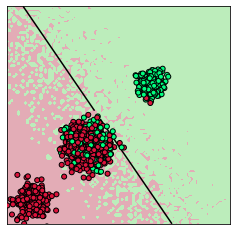

In [5]:
u_to_x2 = lambda x: x
line = Line(1.5, 1, 2)
h_star = StochasticModel(line, max_flip_prob=0.4, slope=0.05)
dist = SyntheticDistribution2D([(-2, -2), (2, 2), (-5.5, -5.5)], u_to_x2, std=[0.6, 0.4, 0.6], clusters_weights=[0.75, 0.15, 0.1])

# line = Line(2, 1, 3)
# h_star = StochasticModel(line, max_flip_prob=0.5, slope=0.04)
# dist = SyntheticDistribution2D([(-2, -2), (2, 2)], u_to_x2, std=[0.6, 0.4], clusters_weights=[0.85, 0.15])
X_U = dist.sample(2000)
X, U = split_vector(X_U, n_features)
Y = create_Y(X, U, h_star, x1_dim)
fig, ax = plt.subplots(figsize=(4, 4))
plot_syth_exp(ax, X.detach().clone(), Y.detach().clone(), h_star=h_star, additional_func=(line, ""), image_scale=7)

In [6]:
scale = 0.035
def h_creator():
    return PolynomialModel(n_features, [1, 2, 3])

stochastic_exp = Experiment2d(f_lr=0.01,
                              h_lr=0.01,
                              batch_size=64,
                              epochs=100,
                              cost_scale=scale,
                              tau=4,
                              time_steps=10,
                              n_clean_train_samples=500,
                              n_samples_per_round=150,
                              total_n_val_test_samples=500,
                              exploration_params=None,
                              dist=dist,
                              u_to_x2=lambda x: x,
                              h_creator=h_creator,
                              h_star=h_star,
                              f_reg=0,
                              h_reg=0,
                              seed=0)

StochasticModel: 16.12% flips
trained 10 epochs. val acc: 0.8202222222222222
StochasticModel: 19.36% flips


#### erm

In [7]:
erm_f = stochastic_exp.run_erm()

trained 7 epochs. val acc: 0.77
	Accuracy: 0.7975
Non-strategic test: 0.7975 accuracy
StochasticModel: 30.25% flips
Strategic test: 0.5475 accuracy


StochasticModel: 14.55% flips


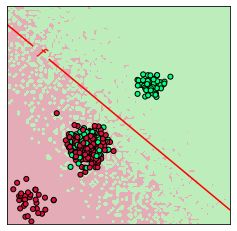

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = plot_syth_exp(ax, stochastic_exp.Xtest.detach().clone(), stochastic_exp.Ytest.detach().clone(), h_star=stochastic_exp.h_star, f=erm_f, image_scale=7)

StochasticModel: 30.25% flips
StochasticModel: 14.55% flips


<AxesSubplot:>

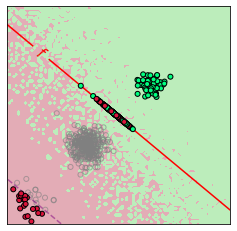

In [10]:
plot_2d_with_movement(erm_f, None, stochastic_exp.h_star, stochastic_exp.delta(erm_f), stochastic_exp.Xtest, stochastic_exp.Utest, stochastic_exp.x1_dim, image_scale=7, cost_scale=scale)

#### serm

In [11]:
serm_f = stochastic_exp.run_serm()

trained 7 epochs. val acc: 0.77
StochasticModel: 20.25% flips
Strategic test: 0.7975 accuracy


StochasticModel: 20.25% flips
StochasticModel: 14.55% flips


<AxesSubplot:>

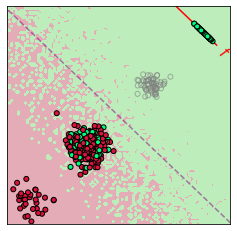

In [12]:
plot_2d_with_movement(serm_f, None, stochastic_exp.h_star, stochastic_exp.delta(serm_f), stochastic_exp.Xtest, stochastic_exp.Utest, stochastic_exp.x1_dim, image_scale=7, cost_scale=scale)

#### cserm

In [13]:
f_list, h_list, test_accs = stochastic_exp.run_cserm()

time step: 1
-----learning h
trained 14 epochs. val acc: 0.7933333333333333
	Accuracy: 0.7933333333333333

-----learning f
trained 7 epochs. val acc: 0.77
trained 9 epochs. val acc: 1.0
StochasticModel: 11.5% flips
	total move: 0.895, pos move (out of total move): 0.369, neg move (out of total move): 0.631,
	pos turn to neg (out of pos move): 0.3409090909090909, neg turn to pos (out of neg move): 0.995575221238938,
	 f.bias: -0.7
	mean likelihood of moving points: 0.0064920298755168915
	Accuracy: 0.885

-----collecting samples
time step: 2
-----learning h
trained 10 epochs. val acc: 0.8256410256410256
	Accuracy: 0.8256410256410256

-----learning f
trained 7 epochs. val acc: 0.77
trained 9 epochs. val acc: 1.0
StochasticModel: 12.75% flips
	total move: 0.89, pos move (out of total move): 0.365, neg move (out of total move): 0.635,
	pos turn to neg (out of pos move): 0.38461538461538464, neg turn to pos (out of neg move): 0.995575221238938,
	 f.bias: -0.72
	mean likelihood of moving poin

StochasticModel: 11.5% flips
StochasticModel: 23.74% flips
StochasticModel: 14.55% flips
StochasticModel: 12.75% flips
StochasticModel: 23.31% flips
StochasticModel: 14.55% flips
StochasticModel: 11.25% flips
StochasticModel: 22.16% flips
StochasticModel: 14.55% flips
StochasticModel: 11.5% flips
StochasticModel: 23.74% flips
StochasticModel: 14.55% flips
StochasticModel: 12.0% flips
StochasticModel: 23.81% flips
StochasticModel: 14.55% flips
StochasticModel: 12.5% flips
StochasticModel: 23.81% flips
StochasticModel: 14.55% flips
StochasticModel: 11.5% flips
StochasticModel: 23.74% flips
StochasticModel: 14.55% flips
StochasticModel: 11.5% flips
StochasticModel: 23.74% flips
StochasticModel: 14.55% flips
StochasticModel: 12.0% flips
StochasticModel: 23.81% flips
StochasticModel: 14.55% flips
StochasticModel: 12.75% flips
StochasticModel: 23.38% flips
StochasticModel: 14.55% flips


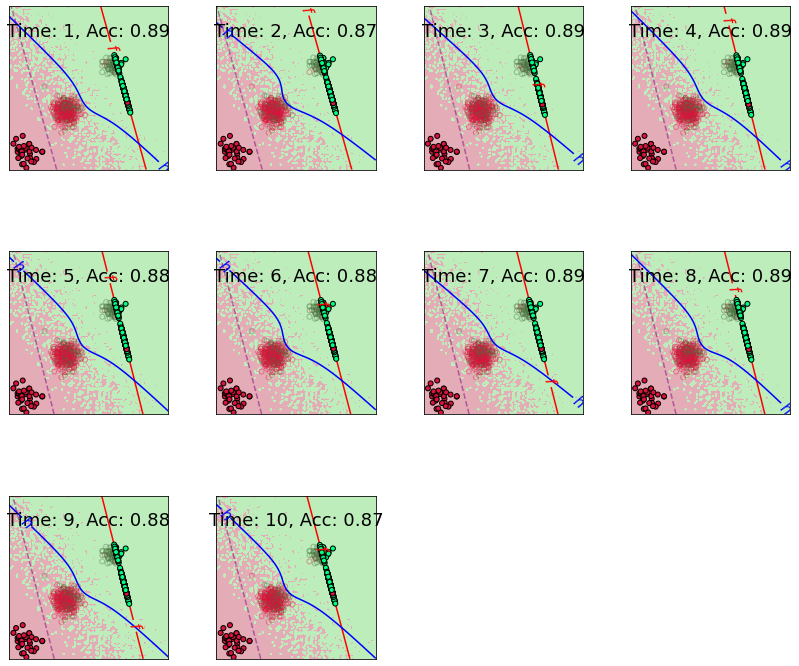

In [14]:
plot_2d_grid(test_accs, f_list, h_list, stochastic_exp.delta(None), stochastic_exp.Xtest, stochastic_exp.Utest, stochastic_exp.h_star, stochastic_exp.time_steps, image_scale=7, cost_scale=scale)

### XOR

<AxesSubplot:>

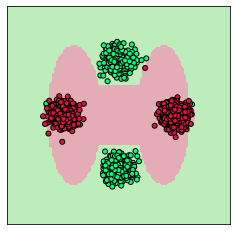

In [15]:
e1 = Elipse(0, 0, 6, 1, 2, -1)
e2 = Elipse(2, 0, 1, 7, 1.5, -1)
e3 = Elipse(-2, 0, 1, 7, 1.5, -1)
h_star = ShapesEnsemble([e1, e2, e3])
dist = SyntheticDistribution2D([(0, 2.5), (-2.5, 0), (0, -2.5), (2.5, 0)], u_to_x2)
X_U = dist.sample(2000)
X, U = split_vector(X_U, n_features)
Y = create_Y(X, U, h_star, x1_dim)
fig, ax = plt.subplots(figsize=(4, 4))
plot_syth_exp(ax, X.detach().clone(), Y.detach().clone(), h_star=h_star)

In [18]:
scale = 0.08

def h_creator():
    return PolynomialModel(n_features, [1, 2, 3, 4])


xor_exp = Experiment2d(f_lr=0.05,
                      h_lr=0.01,
                      batch_size=64,
                      epochs=100,
                      cost_scale=scale,
                      tau=20,
                      time_steps=10,
                      n_clean_train_samples=500,
                      n_samples_per_round=150,
                      total_n_val_test_samples=500,
                      exploration_params=ExplorationParams(should_use=True, coef=5, decay=0.4), # coef=10
                      dist=dist,
                      u_to_x2=lambda x: x,
                      h_creator=h_creator,
                      h_star=h_star,
                      f_reg=1,
                      h_reg=0.01,
                      seed=3)

trained 7 epochs. val acc: 1.0


#### erm

In [19]:
erm_f = xor_exp.run_erm()

trained 16 epochs. val acc: 0.59
	Accuracy: 0.4875
Non-strategic test: 0.4875 accuracy
Strategic test: 0.495 accuracy


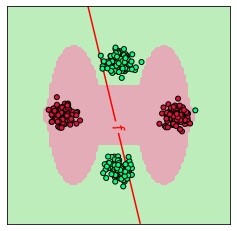

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = plot_syth_exp(ax, xor_exp.Xtest.detach().clone(), xor_exp.Ytest.detach().clone(), h_star=xor_exp.h_star, f=erm_f, image_scale=5)

<AxesSubplot:>

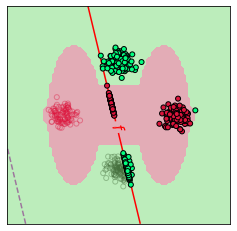

In [22]:
plot_2d_with_movement(erm_f, None, xor_exp.h_star, xor_exp.delta(erm_f), xor_exp.Xtest, xor_exp.Utest, xor_exp.x1_dim, cost_scale=scale)

#### serm

In [23]:
serm_f = xor_exp.run_serm()

trained 16 epochs. val acc: 0.59
Strategic test: 0.28 accuracy


<AxesSubplot:>

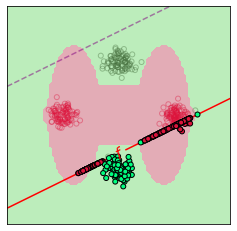

In [24]:
plot_2d_with_movement(serm_f, None, xor_exp.h_star, xor_exp.delta(serm_f), xor_exp.Xtest, xor_exp.Utest, xor_exp.x1_dim, image_scale=5, cost_scale=scale)

#### cserm

In [25]:
f_list, h_list, test_accs = xor_exp.run_cserm()

time step: 1
-----learning h
trained 9 epochs. val acc: 1.0
	Accuracy: 1.0

-----learning f
trained 19 epochs. val acc: 0.78
trained 7 epochs. val acc: 0.44999999999999996
	total move: 0.733, pos move (out of total move): 0.56, neg move (out of total move): 0.44,
	pos turn to neg (out of pos move): 0.4451219512195122, neg turn to pos (out of neg move): 0.0,
	 f.bias: -2.36
	mean likelihood of moving points: 0.22828416526317596
	Accuracy: 0.3125

-----collecting samples
time step: 2
-----learning h
trained 15 epochs. val acc: 0.9487179487179487
	Accuracy: 0.9487179487179487

-----learning f
trained 19 epochs. val acc: 0.78
trained 7 epochs. val acc: 0.45999999999999996
	total move: 0.252, pos move (out of total move): 0.079, neg move (out of total move): 0.921,
	pos turn to neg (out of pos move): 0.0, neg turn to pos (out of neg move): 0.0,
	 f.bias: 0.232
	mean likelihood of moving points: 0.007220367435365915
	Accuracy: 0.495

-----collecting samples
time step: 3
-----learning h
train

C:\Users\guy.h\OneDrive - Technion\csc_new\plot_data.py:139: UserWarning: No contour levels were found within the data range.
  contours = ax.contour(x1_grid.detach().numpy(), x2_grid.detach().numpy(), scores_grid.detach().numpy(), levels=levels, colors=colors, **kwargs)


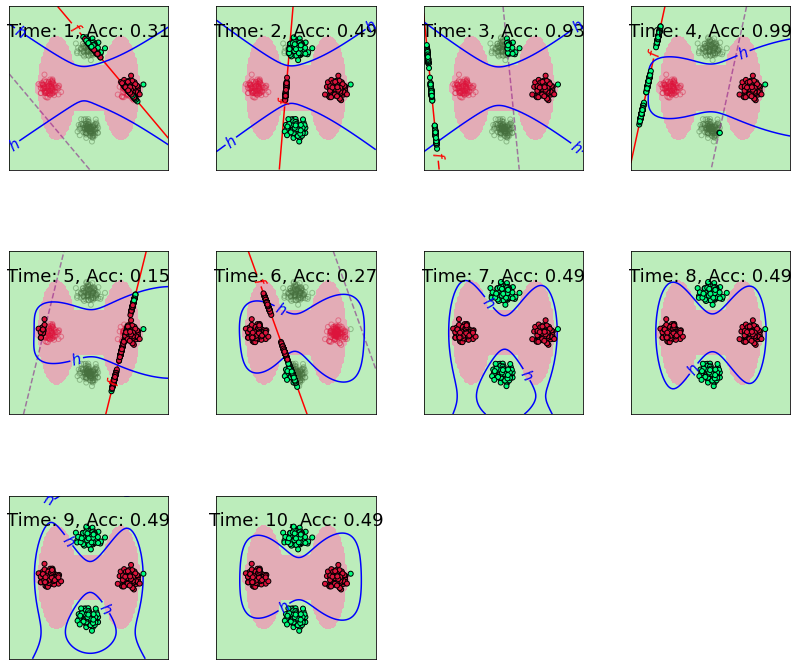

In [26]:
plot_2d_grid(test_accs, f_list, h_list, xor_exp.delta(None), xor_exp.Xtest, xor_exp.Utest, xor_exp.h_star, xor_exp.time_steps, image_scale=5, cost_scale=scale)

### Circle
This example is a harder case of the elipse example.\
Here there is only one optimal solution: use only $X_c$ and put high so only positive points can move

<AxesSubplot:>

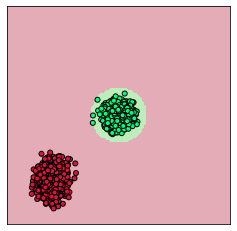

In [28]:
h_star = Circle(0, 0, 1.5)
# h_star = Elipse(-2, 0, 6, 1, 1.5)
dist = CustomSyntheticDataDistribution2(x1_dim, u_to_x2)
X_U = dist.sample(2000)
X, U = split_vector(X_U, n_features)
Y = create_Y(X, U, h_star, x1_dim)
fig, ax = plt.subplots(figsize=(4, 4))
plot_syth_exp(ax, X.detach().clone(), Y.detach().clone(), h_star=h_star)

In [29]:
scale = 0.07

def h_creator():
    return PolynomialModel(n_features, [1, 2, 3])


circle_exp = Experiment2d(f_lr=0.1,
                          h_lr=0.1,
                          batch_size=64,
                          epochs=100,
                          cost_scale=scale,
                          tau=20,
                          time_steps=10,
                          n_clean_train_samples=500,
                          n_samples_per_round=150,
                          total_n_val_test_samples=500,
                          exploration_params=None,
                          dist=dist,
                          u_to_x2=lambda x: x,
                          h_creator=h_creator,
                          h_star=h_star,
                          f_reg=0.1,
                          h_reg=0.0,
                          seed=0)

trained 7 epochs. val acc: 1.0


#### erm

In [30]:
erm_f = circle_exp.run_erm()

trained 7 epochs. val acc: 1.0
	Accuracy: 1.0
Non-strategic test: 1.0 accuracy
Strategic test: 0.495 accuracy


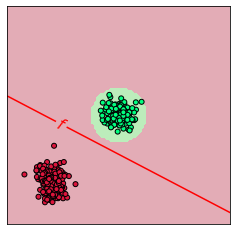

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = plot_syth_exp(ax, circle_exp.Xtest.detach().clone(), circle_exp.Ytest.detach().clone(), h_star=circle_exp.h_star, f=erm_f, image_scale=5)

<AxesSubplot:>

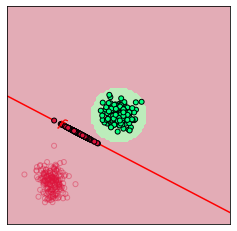

In [32]:
plot_2d_with_movement(erm_f, None, circle_exp.h_star, circle_exp.delta(erm_f), circle_exp.Xtest, circle_exp.Utest, circle_exp.x1_dim, image_scale=5, cost_scale=scale)

#### serm

In [33]:
serm_f = circle_exp.run_serm()

trained 7 epochs. val acc: 1.0
Strategic test: 0.505 accuracy


<AxesSubplot:>

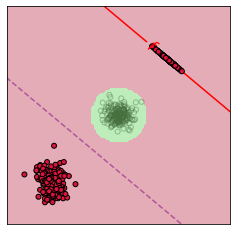

In [34]:
plot_2d_with_movement(serm_f, None, circle_exp.h_star, circle_exp.delta(serm_f), circle_exp.Xtest, circle_exp.Utest, circle_exp.x1_dim, cost_scale=scale)

#### cserm

In [35]:
f_list, h_list, test_accs = circle_exp.run_cserm()

time step: 1
-----learning h
trained 8 epochs. val acc: 1.0
	Accuracy: 1.0

-----learning f
trained 8 epochs. val acc: 1.0
trained 9 epochs. val acc: 1.0
	total move: 0.495, pos move (out of total move): 1.0, neg move (out of total move): 0.0,
	pos turn to neg (out of pos move): 1.0, neg turn to pos (out of neg move): 0,
	 f.bias: -2.428
	mean likelihood of moving points: 0.0
	Accuracy: 0.505

-----collecting samples
time step: 2
-----learning h
trained 8 epochs. val acc: 1.0
	Accuracy: 1.0

-----learning f
trained 8 epochs. val acc: 1.0
trained 12 epochs. val acc: 1.0
	total move: 0.498, pos move (out of total move): 0.995, neg move (out of total move): 0.005,
	pos turn to neg (out of pos move): 0.050505050505050504, neg turn to pos (out of neg move): 0.0,
	 f.bias: -2.95
	mean likelihood of moving points: 0.0
	Accuracy: 0.9725

-----collecting samples
time step: 3
-----learning h
trained 7 epochs. val acc: 0.9916666666666667
	Accuracy: 0.9916666666666667

-----learning f
trained 8 ep

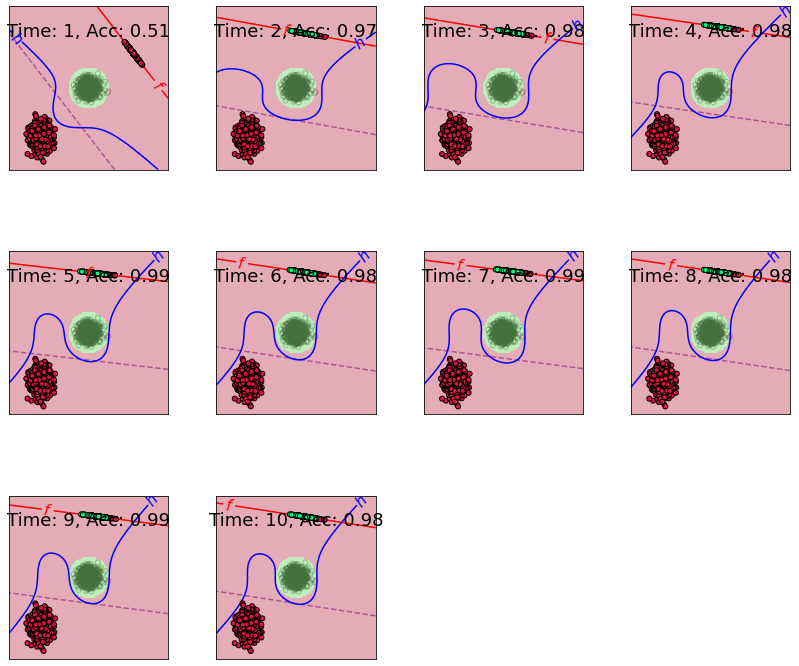

In [36]:
plot_2d_grid(test_accs, f_list, h_list, circle_exp.delta(None), circle_exp.X, circle_exp.U, circle_exp.h_star, circle_exp.time_steps, cost_scale=scale)

### Vertical elipse
- In this example, the non-causal strategic baseline is very sub-optimal. Raising the bar simultaneously in both features is a mistake.
- In this example there are two optimal solutions (that I could think of):
    1. diagonal line in the top of the elipse (this is the solution that our algorithm finds), and this is an example for optimal solution that uses both features 
    2. use only $X_c$ and put high so only positive points can move

<AxesSubplot:xlabel='$x_c$', ylabel='$x_r$'>

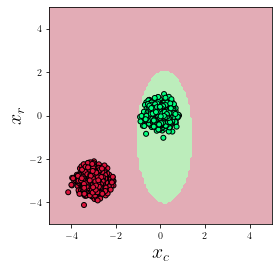

In [274]:
h_star = Elipse(0.2, -1, 1, 6, 1.5)
dist = SyntheticDistribution2D([(-3, -3), (0, 0)], u_to_x2)
X_U = dist.sample(2000)
X, U = split_vector(X_U, n_features)
Y = create_Y(X, U, h_star, x1_dim)
fig, ax = plt.subplots(figsize=(4, 4))
plot_syth_exp(ax, X.detach().clone(), Y.detach().clone(), h_star=h_star)

In [277]:
scale = 0.07

def h_creator():
    return PolynomialModel(n_features, [1, 2, 3])


elipse_exp = Experiment2d(f_lr=0.1,
                          h_lr=0.01,
                          batch_size=64,
                          epochs=100,
                          cost_scale=scale,
                          tau=20,
                          time_steps=10,
                          n_clean_train_samples=500,
                          n_samples_per_round=150,
                          total_n_val_test_samples=500,
                          exploration_params=None,
                          dist=dist,
                          u_to_x2=lambda x: x,
                          h_creator=h_creator,
                          h_star=h_star,
                          f_reg=0.1,
                          h_reg=0.01,
                          seed=0)

trained 7 epochs. val acc: 1.0


#### erm

In [278]:
erm_f = elipse_exp.run_erm()

trained 7 epochs. val acc: 1.0
	Accuracy: 1.0
Non-strategic test: 1.0 accuracy
Strategic test: 0.505 accuracy


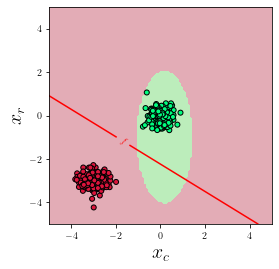

In [280]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = plot_syth_exp(ax, elipse_exp.Xtest.detach().clone(), elipse_exp.Ytest.detach().clone(), h_star=elipse_exp.h_star, f=erm_f, scale=5)

<AxesSubplot:xlabel='$x_c$', ylabel='$x_r$'>

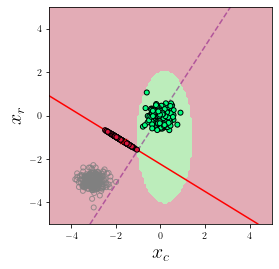

In [281]:
plot_2d_with_movement(erm_f, None, elipse_exp.h_star, elipse_exp.delta(erm_f), elipse_exp.Xtest, elipse_exp.Utest, elipse_exp.x1_dim)

#### serm

In [282]:
serm_f = elipse_exp.run_serm()

trained 7 epochs. val acc: 1.0
Strategic test: 0.495 accuracy


<AxesSubplot:xlabel='$x_c$', ylabel='$x_r$'>

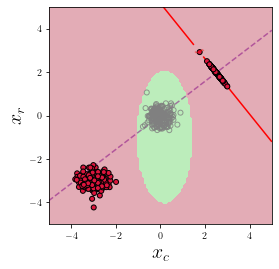

In [283]:
plot_2d_with_movement(serm_f, None, elipse_exp.h_star, elipse_exp.delta(serm_f), elipse_exp.Xtest, elipse_exp.Utest, elipse_exp.x1_dim, scale=5)

#### cserm

In [284]:
f_list, h_list, test_accs = elipse_exp.run_cserm()

time step: 1
-----learning h
trained 12 epochs. val acc: 1.0
	Accuracy: 1.0

-----learning f
trained 8 epochs. val acc: 1.0
trained 10 epochs. val acc: 1.0
	total move: 0.505, pos move (out of total move): 1.0, neg move (out of total move): 0.0,
	pos turn to neg (out of pos move): 1.0, neg turn to pos (out of neg move): 0,
	 f.bias: -2.55
	mean likelihood of moving points: 0.0
	Accuracy: 0.495

-----collecting samples
time step: 2
-----learning h
trained 11 epochs. val acc: 1.0
	Accuracy: 1.0

-----learning f
trained 8 epochs. val acc: 1.0
trained 20 epochs. val acc: 0.99
	total move: 0.505, pos move (out of total move): 1.0, neg move (out of total move): 0.0,
	pos turn to neg (out of pos move): 0.0, neg turn to pos (out of neg move): 0,
	 f.bias: -4.128
	mean likelihood of moving points: 0.0
	Accuracy: 1.0

-----collecting samples
time step: 3
-----learning h
trained 12 epochs. val acc: 1.0
	Accuracy: 1.0

-----learning f
trained 8 epochs. val acc: 1.0
trained 13 epochs. val acc: 1.0


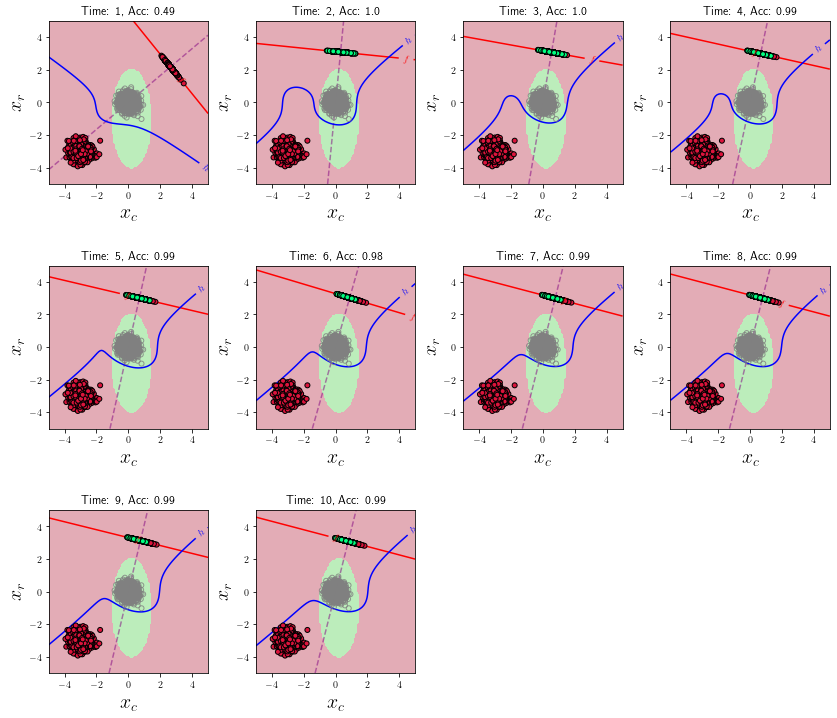

In [286]:
plot_2d_grid(test_accs, f_list, h_list, elipse_exp.delta(None), elipse_exp.X, elipse_exp.U, elipse_exp.h_star, elipse_exp.time_steps)